In [1]:
import numpy as np
import matplotlib.pyplot as plt
from yolov7_package import Yolov7Detector
import matplotlib.patches as patches

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

from segment_track.observation import Observation
from segment_track.segment import Segment

In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.05,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.05,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

In [3]:
T_BC = np.array([
    - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
    -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
yolov7_det = Yolov7Detector(traced=False)
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params


/home/masonbp/.envs/motlee/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Fusing layers... 


In [4]:
def detect_person(img):
    classes, boxes, scores = yolov7_det.detect(img)
    person_boxes = []
    for i, cl in enumerate(classes[0]):
        if yolov7_det.names[cl] == 'person':
            person_boxes.append(boxes[0][i])
    
    if len(person_boxes) > 1:
        return None
    if len(person_boxes) == 0:
        return None
    box = person_boxes[0]
    x0, y0, x1, y1 = np.array(box).astype(np.int64).reshape(-1).tolist()
    return np.array([(x1 - x0) / 2 + x0, (y1 - y0) / 2 + y0])

In [5]:
# for t in np.arange(187, 191, .1):
for t in np.linspace(187, 191, 20):
    img = img_data.img(t)
    centroid = detect_person(img)
    # plt.imshow(img[..., ::-1])
    # print(centroid)
    # plt.gca().add_patch(patches.Circle((centroid[0], centroid[1]), 20, color='r'))
    # plt.show()
    if centroid is None:
        print("No person detected")
        continue
    pose = pose_data.T_WB(t)
    obs = Observation(t, pose, centroid, 0, 0)

    if t == 187:
        segment = Segment(obs, cam_params, 10.)
    else:
        segment.update(obs)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/motlee/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


No person detected
No person detected
No person detected


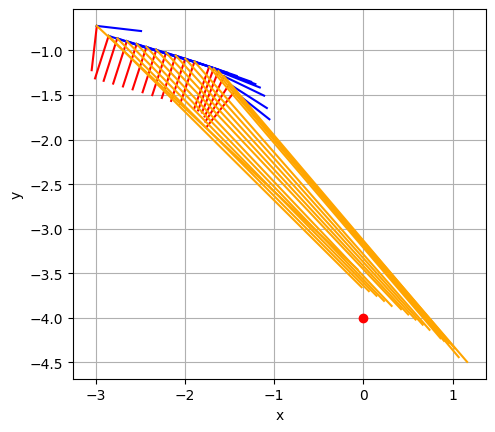

In [6]:
plt.plot(0, -4, 'ro')
for obs in segment.observations:
    pose_data.plot2d(t=obs.time, pose=True, axis_len=.5)
    
for obs in segment.observations[:]:
    det_vec_c = np.linalg.inv(cam_params.K) @ np.array([obs.pixel[0], obs.pixel[1], 1]).reshape((3,1))
    det_vec = obs.pose[:3,:3] @ det_vec_c
    det_vec = det_vec[:2] / np.linalg.norm(det_vec[:2])
    det_vec *= 4
    plt.plot([obs.pose[0,3], obs.pose[0,3] + det_vec.item(0)], [obs.pose[1,3], obs.pose[1,3] + det_vec.item(1)], 'orange')

plt.gca().set_aspect('equal', adjustable='box')

In [7]:
segment.reconstruction3D()

array([     2.1956,     -5.8088,      1.1388])

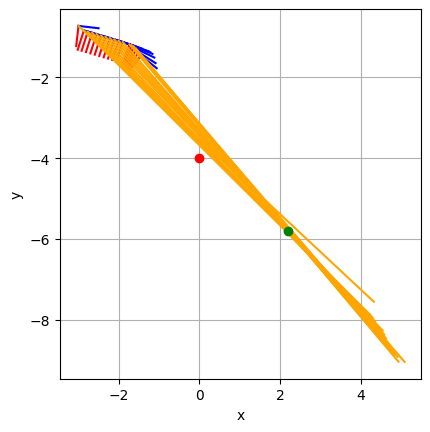

In [8]:
plt.plot(0, -4, 'ro')
for obs in segment.observations:
    pose_data.plot2d(t=obs.time, pose=True, axis_len=.5)
    
for obs in segment.observations[:]:
    det_vec_c = np.linalg.inv(cam_params.K) @ np.array([obs.pixel[0], obs.pixel[1], 1]).reshape((3,1))
    det_vec = obs.pose[:3,:3] @ det_vec_c
    det_vec = det_vec[:2] / np.linalg.norm(det_vec[:2])
    det_vec *= 10
    plt.plot([obs.pose[0,3], obs.pose[0,3] + det_vec.item(0)], [obs.pose[1,3], obs.pose[1,3] + det_vec.item(1)], 'orange')
    
est3d = segment.reconstruction3D()
plt.plot(est3d[0], est3d[1], 'go')
plt.gca().set_aspect('equal', adjustable='box')

In [9]:
import gtsam
points = []
for obs in segment.observations:
    points.append(gtsam.Point2(obs.pixel))
gtsam.Point2Vector(points)
pixels_point_vec = gtsam.Point2Vector([gtsam.Point2(obs.pixel) for obs in segment.observations])

In [10]:
segment.reconstruction3D()


array([     2.1956,     -5.8088,      1.1388])